In [1]:
# construct delta_X_o, 66x66 matrix, each column specifies emission occuring in one month over one of 22 regions

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 200
rcParams["font.size"] = 12

import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs      # map projections
import regionmask
import pandas as pd
from gamap_colormap import WhGrYlRd  # import the "WhGrYlRd" variable from custom Python script
from functions import area_latlon # function to calculate grid area

In [4]:
output_directory = '/geos/u73/msadiq/GEOS-Chem/analysis/python/data/'

In [5]:
emission_file = '/geos/u73/msadiq/GEOS-Chem/HEMCO/CO2/v2019-12/EDGAR_v5_CO2_1970-2018.0.1x0.1.nc'
ds_emission = xr.open_dataset(emission_file)

In [6]:
ds_emission

<xarray.Dataset>
Dimensions:  (lat: 1800, lon: 3600, time: 49)
Coordinates:
  * time     (time) datetime64[ns] 1970-01-01 1971-01-01 ... 2017-12-20
  * lat      (lat) float32 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
  * lon      (lon) float32 0.05 0.15 0.25 0.35 ... 359.65 359.75 359.85 359.95
Data variables:
    emi_co2  (time, lat, lon) float32 ...
Attributes:
    Conventions:               CF-1.0
    title:                     Annual Mean Emissions of CO2 - 
    institution:               European Commission, Joint Research Centre
    source:                    http://edgar.jrc.ec.europa.eu/
    history:                   Mon Dec  2 13:46:50 2019: ncap2 -s time=(time-...
    references:                European Commission, Joint Research Centre (JR...
    copyright_notice:          Reproduction of the data is authorized, except...
    contact:                   JRC-EDGAR@ec.europa.eu
    NCO:                       netCDF Operators version 4.7.5 (Homepage = htt...
    nco_openmp_thread_number:  1

In [7]:
year_of_emission = ds_emission['emi_co2'].isel(time = 48) # unit: kg/m2/s
dr = year_of_emission.copy()
# calculate grid area (using the area_latlon) and multiply to the emission flux
for count, lat in enumerate(dr['lat'].values):
    area = area_latlon(lat1=lat, lat2=lat+0.1, lon1=10, lon2=10.1) # km^2, also longitude doesn't matter
    dr[count,:] = year_of_emission.values[count,:]*area*3600*24*365*1e-6*12/44 # GtC/year

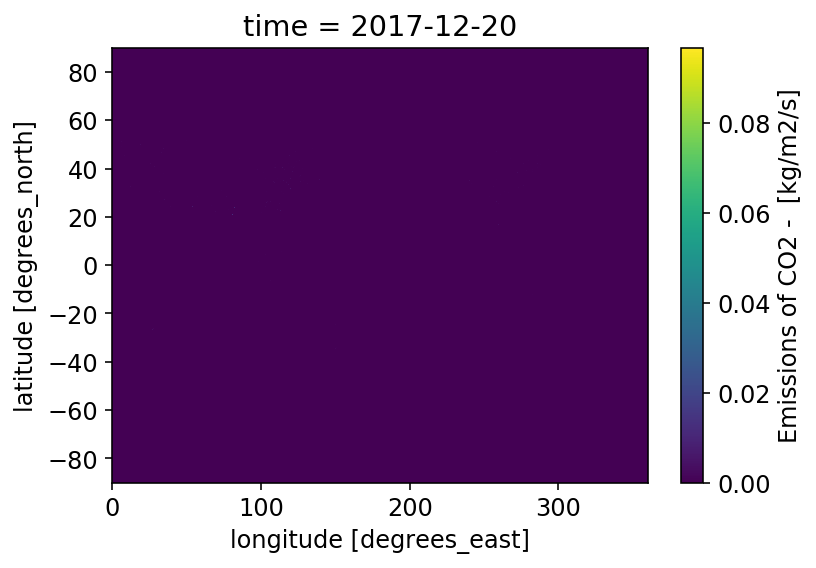

In [8]:
dr.plot()

In [9]:
mask = regionmask.defined_regions.giorgi.mask(year_of_emission)

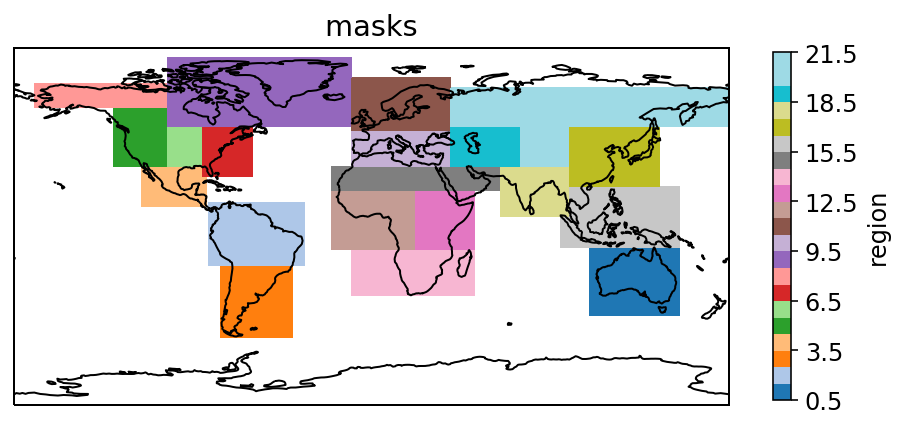

In [10]:
# global map
fig = plt.figure(figsize=[8, 4])
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)

low = mask.min()
high = mask.max()
levels = np.arange(low - 0.5, high + 1)

mask.plot(ax=ax, transform=ccrs.PlateCarree(), levels=levels, cmap='tab20', vmax = 21.5, cbar_kwargs={'shrink': 0.8,})
ax.set_title(" masks ")
ax.coastlines();

In [11]:
# sum up each box
co2_regional = dr.groupby(mask).sum('stacked_lat_lon')

In [12]:
names = regionmask.defined_regions.giorgi[co2_regional.region.values].names
names

['Australia',
 'Amazon Basin',
 'Southern South America',
 'Central America',
 'Western North America',
 'Central North America',
 'Eastern North America',
 'Alaska',
 'Greenland',
 'Mediterranean Basin',
 'Northern Europe',
 'Western Africa',
 'Eastern Africa',
 'Southern Africa',
 'Sahara',
 'Southeast Asia',
 'East Asia',
 'South Asia',
 'Central Asia',
 'Tibet',
 'North Asia']

In [13]:
co2_regional.sel(region = 21)
co2_regional.values

array([0.11963632, 0.17670316, 0.15813407, 0.20480374, 0.38481966,
       0.54975456, 0.61489147, 0.01007848, 0.01956231, 0.70900464,
       0.89628804, 0.06901742, 0.03701489, 0.14972824, 0.3942316 ,
       0.4077147 , 3.6574602 , 0.8012342 , 0.40581736, 0.10873144,
       0.29448608], dtype=float32)

In [14]:
mask_nan = np.isnan(mask)
a = mask_nan.where(True)
#tmp = a*year_of_emission
tmp = a*dr
#ocean_mean = tmp.mean()
ocean_mean = tmp.sum()
ocean_mean

<xarray.DataArray ()>
array(0.15773018)
Coordinates:
    time     datetime64[ns] 2017-12-20

In [15]:
new_co2_region = np.append(co2_regional.values, ocean_mean)
new_names = np.append(names, 'Ocean')

data = {'name': new_names, 'emission': new_co2_region}
df = pd.DataFrame(data) 
print(df)
df.to_csv(output_directory + 'base_emission.csv')

                      name  emission
0                Australia  0.119636
1             Amazon Basin  0.176703
2   Southern South America  0.158134
3          Central America  0.204804
4    Western North America  0.384820
5    Central North America  0.549755
6    Eastern North America  0.614891
7                   Alaska  0.010078
8                Greenland  0.019562
9      Mediterranean Basin  0.709005
10         Northern Europe  0.896288
11          Western Africa  0.069017
12          Eastern Africa  0.037015
13         Southern Africa  0.149728
14                  Sahara  0.394232
15          Southeast Asia  0.407715
16               East Asia  3.657460
17              South Asia  0.801234
18            Central Asia  0.405817
19                   Tibet  0.108731
20              North Asia  0.294486
21                   Ocean  0.157730


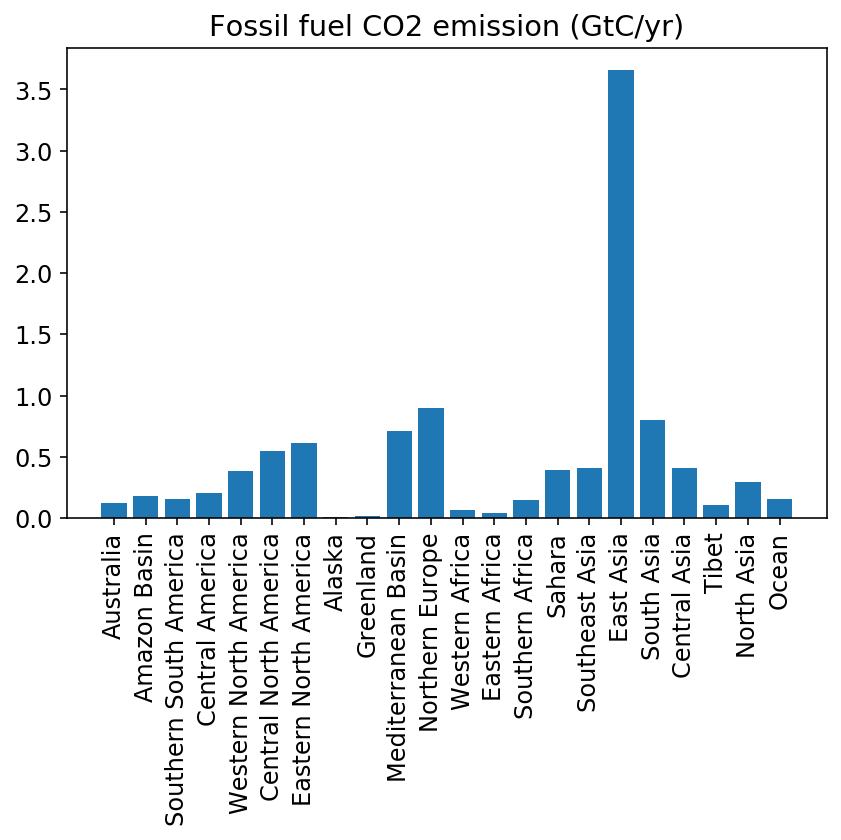

In [18]:
fig = plt.figure(figsize=[6, 6])
plt.bar(new_names, new_co2_region)
plt.title('Fossil fuel CO2 emission (GtC/yr)')
plt.xticks(rotation=90)
fig.tight_layout()

fig.savefig(output_directory+'regional_total_22.png', dpi=300)

In [19]:
number_tags = 22
number_ens = 3
total = number_tags * number_ens
delta_X_o = np.array(np.zeros(total*total)).reshape((total, total))
delta_X_o

for iens in range(number_ens):
    for itag in range(number_tags):
        delta_X_o[iens*number_tags+itag,iens*number_tags+itag] = new_co2_region[itag]

Text(0.5, 1.0, 'delta_X_o matrix')

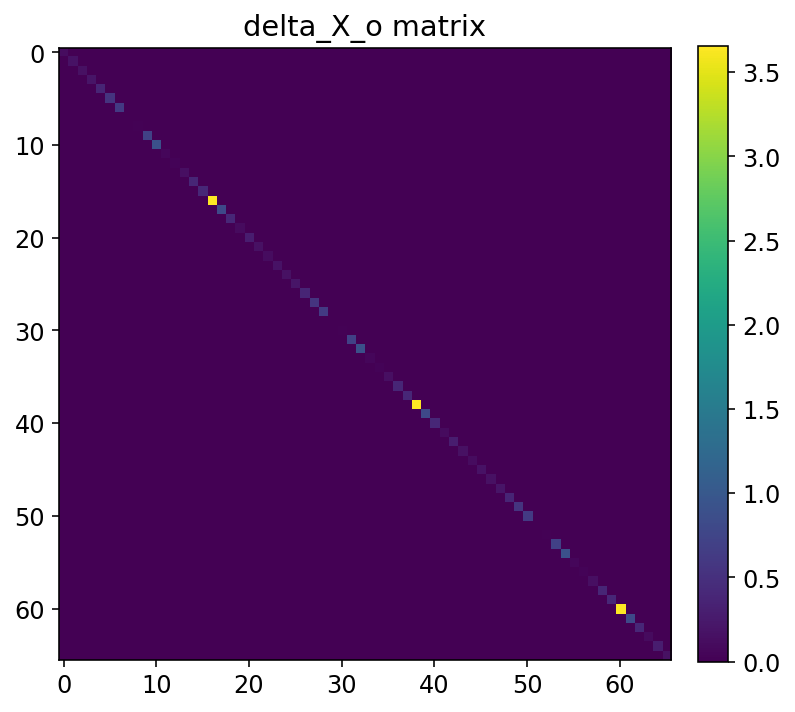

In [20]:
fig = plt.figure(figsize=[6, 6])
plt.imshow(delta_X_o)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('delta_X_o matrix')
#fig.savefig(output_directory+'regional_mean_22.png', dpi=300)

Text(0.5, 1.0, 'inverse of delta_X_o matrix')

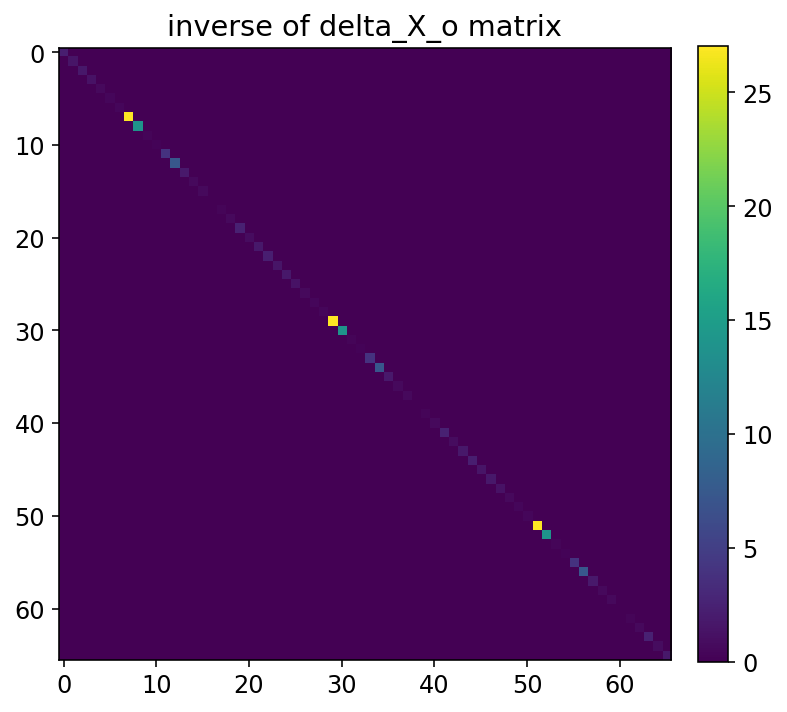

In [18]:
inv_delta_X_o = np.linalg.inv(delta_X_o)

fig = plt.figure(figsize=[6, 6])
plt.imshow(inv_delta_X_o)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('inverse of delta_X_o matrix')
#fig.savefig(output_directory+'regional_mean_22.png', dpi=300)

Text(0.5, 1.0, 'delta_X_f matrix')

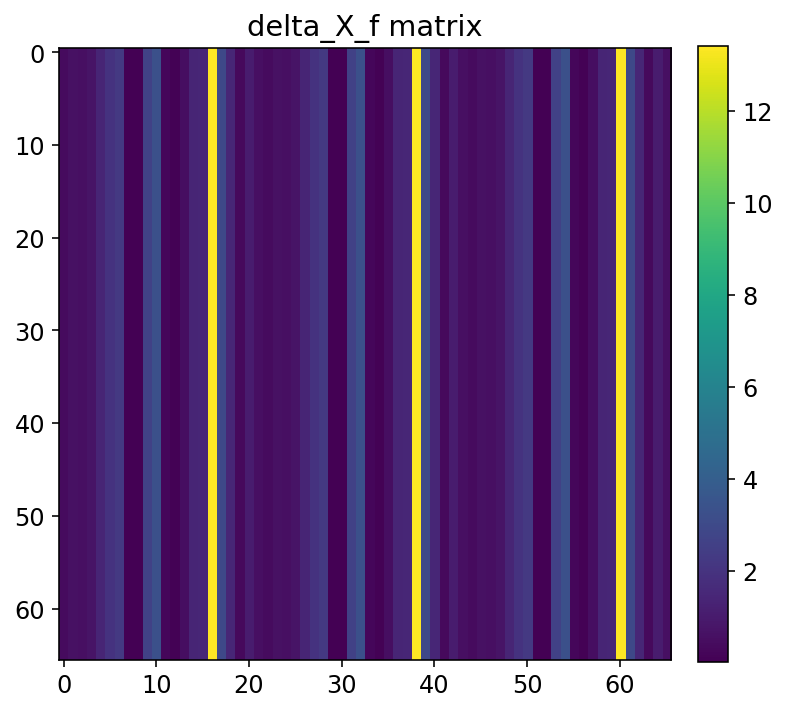

In [19]:
delta_X_f = np.array(np.zeros(total*total)).reshape((total, total))
delta_X_f

co2_regional_long = np.tile(new_co2_region, 3)

for i in range(total):
    delta_X_f[i,:] = co2_regional_long

fig = plt.figure(figsize=[6, 6])
plt.imshow(delta_X_f)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('delta_X_f matrix')

Text(0.5, 1.0, 'delta_X_f matrix')

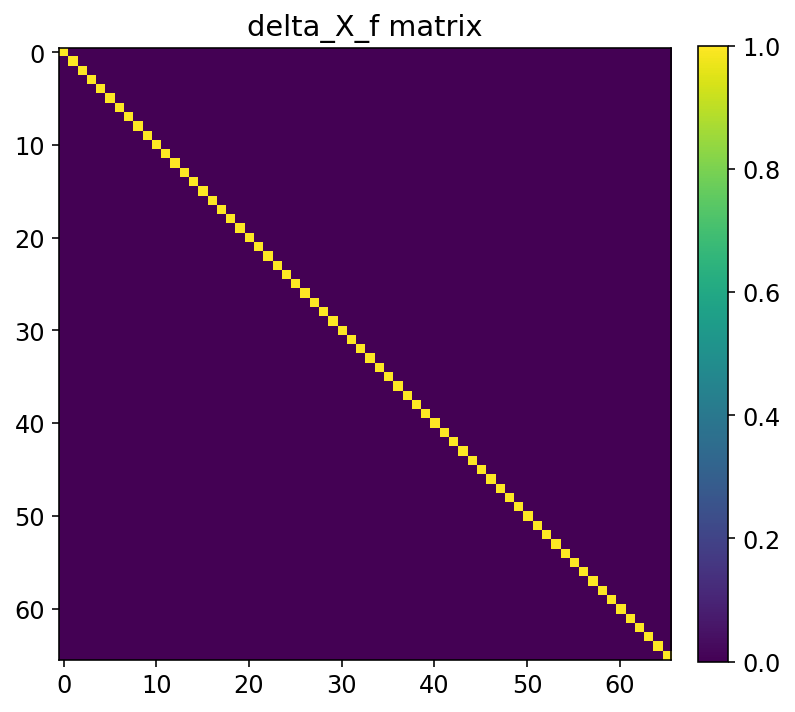

In [20]:
# inverse of delta_X_o times delta_X_f
mult = inv_delta_X_o * delta_X_f

fig = plt.figure(figsize=[6, 6])
plt.imshow(mult)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('delta_X_f matrix')

In [21]:
emission_2degree_file = '/geos/u73/msadiq/GEOS-Chem/analysis/python/data/EDGAR_2x2.5_2018_1x1.nc'
emission_2degree = xr.open_dataset(emission_2degree_file)
emission_2degree
flat = emission_2degree['emi_co2'].to_dataframe() # flatten a variable at one level
flat.reset_index(inplace=True) # get indices to prepare output coordinates
flat#['emi_co2'].values

,lat,lon,emi_co2
0,-90.0,-180.0,0.0
1,-90.0,-177.5,0.0
2,-90.0,-175.0,0.0
3,-90.0,-172.5,0.0
4,-90.0,-170.0,0.0
...,...,...,...
13099,90.0,167.5,0.0
13100,90.0,170.0,0.0
13101,90.0,172.5,0.0
13102,90.0,175.0,0.0


In [22]:
target_file = '/geos/u73/msadiq/GEOS-Chem/analysis/python/data/XCO2_mod_oco2.nc'
target = xr.open_dataset(target_file)
target.lon.values

FileNotFoundError: [Errno 2] No such file or directory: b'/geos/u73/msadiq/GEOS-Chem/analysis/python/data/XCO2_mod_oco2.nc'

In [ ]:
days = len(list(set(target['date'].values)))
step = len(emission_2degree['lat']) * len(emission_2degree['lon'])
step

In [ ]:
tmp_dr = target['diff']
tmp_dr[:] = 0.0
for iday in range(days):
    tmp_dr[iday*step:(iday+1)*step] = flat['emi_co2'].values

In [ ]:
target['prior'] = tmp_dr
target

In [ ]:
target.to_netcdf('/geos/u73/msadiq/GEOS-Chem/analysis/python/data/inversion.nc')